In [3]:
#%matplotlib inline
#%matplotlib widget
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob
from PIL import Image

## set the following appropriately
PH_PROG = "CubicalRipser.exe"
PH_PROG = "./cubicalripser"
volfile = "vol.npy"
ph_out = "PH.npy"

In [74]:
# load image files and stack into a 3D array
input_files = "*.jpg"
files = sorted([f for f in glob.glob(input_files)])
img = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
np.save(volfile,img[:500,:500,:500])
print(img.shape, img.dtype, np.min(img),np.max(img))

(512, 512, 9) float64 0.0 255.0


In [4]:
# compute PH (takes time)
start = time.time()
result = subprocess.run(PH_PROG+' --output '+ph_out+' '+volfile, shell=True)
print(result)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

CompletedProcess(args='./cubicalripser --output PH.npy vol.npy', returncode=0)
elapsed_time:12.919109106063843[sec]


In [5]:
# load computed PH
pd = np.load(ph_out)
pd0 = pd[pd[:,0] == 0]
pd1 = pd[pd[:,0] == 1]
pd2 = pd[pd[:,0] == 2]
print("#0-cycle {}, #1-cycle {}, #2-cycle {}".format(len(pd0),len(pd1),len(pd2)))
# each line contains (dim,birth,death,x,y,z)
print(pd0[:5])
print(pd1[:5])
print(pd2[:5])

#0-cycle 47926, #1-cycle 60578, #2-cycle 16253
[[  0.   0.   1.   1. 326.   7.]
 [  0.   0.   1. 494. 358.   3.]
 [  0.   0.   1.   6. 319.   9.]
 [  0.   0.   1.   5. 318.   8.]
 [  0.   0.   1.   1. 309.   8.]]
[[  1. 231. 239.  52. 220.   6.]
 [  1. 230. 234.  64. 329.   3.]
 [  1. 230. 231.  52. 218.   6.]
 [  1. 229. 230.  53. 290.   4.]
 [  1. 229. 230.  50. 257.   5.]]
[[  2. 254. 255. 374. 180.   5.]
 [  2. 241. 242.  47. 254.   5.]
 [  2. 241. 242.  51. 289.   4.]
 [  2. 241. 242.  54. 223.   6.]
 [  2. 241. 248. 392. 224.   7.]]


In [6]:
# compute the heatmap of selected cycles
img = np.load(volfile)
mx,my,mz=img.shape
selected_cycle = np.zeros(img.shape)
h=3
min_life = 10
max_life =255
min_birth = 0
max_birth = 255
dimension = 0
pds = pd[pd[:,0] == dimension ]
pds = pds[min_life < pds[:,2]-pds[:,1]]
pds = pds[pds[:,2]-pds[:,1] < max_life]
pds = pds[min_birth < pds[:,1]]
pds = pds[pds[:,1] < max_birth]

print(pds.shape)
for c in pds:
    x,y,z=int(c[3])-1,int(c[4])-1,int(c[5])-1
#    selected_cycle[x,y,z] += 1
    selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += 1

print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))

(7451, 6)
0.0 14.0 1358310.0


<IPython.core.display.Javascript object>


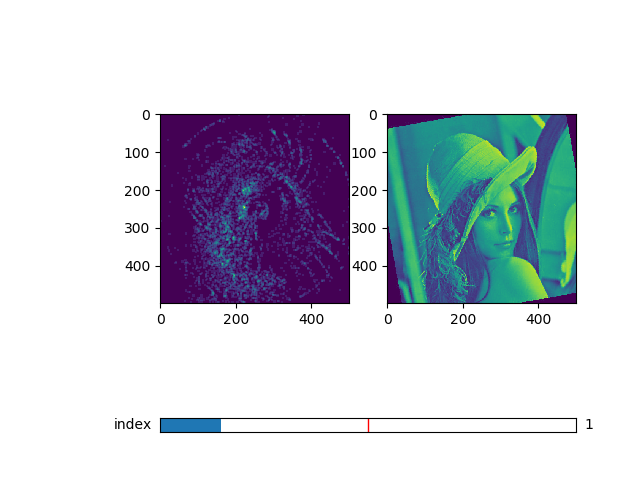

In [78]:
# Visualise 
vol = selected_cycle
#vol = selected_cycle > 300
fig = plt.figure()
fig.subplots_adjust(left=0.25, bottom=0.25)
ax = plt.subplot(121)
ind = vol.shape[2]//2
l = ax.imshow(vol[:,:,ind])
ax = plt.subplot(122)
l2 = ax.imshow(img[:,:,ind])
def update(val):
    ind = int(slider.val)
    l.set_data(vol[:,:,ind])
    l2.set_data(img[:,:,ind])
    fig.canvas.draw()        
ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(ax, 'index', 0, vol.shape[2] - 1, valinit=ind, valfmt='%i')
slider.on_changed(update)
plt.show()